In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.io import savemat, loadmat
import matlab.engine # to run Cheng's code
import time

# add the path to my packages to system paths so they can be imported
import sys
# sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/simgraph/code/my_packages')
sys.path.append('F:/Users/yasam/Documents/GitHub/simgraph/code/my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import simgraph.my_simgraph as sg
import dataprocess.data_handler_03 as dh

In [8]:
# import importlib
# importlib.reload(sg)

# Load and group neuron spike data

In [9]:
# load all spike data from file
spikes_dp = '../../../local_data/original_files/'
grouped_data = np.load(spikes_dp+'summed_spikes.npy') # you can load alternative files from the same directory

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

In [10]:
grouped_data.shape

(297, 1141, 1)

In [11]:
# visualize the response data
length = grouped_data.shape[0] * grouped_data.shape[1]
lbl_min = int(np.min(grouped_data))
lbl_max = int(np.max(grouped_data))
print('labels range from {} to {}.'.format(lbl_min, lbl_max))

print('label      | percentage belonging to label   ')
print('---------------------------------------------')
sanity = 0
for lbl in range(lbl_min, lbl_max+1):
    class_perc = 100*float(sum(sum(grouped_data == lbl))) / length
    print('label #{:3} | {:.2f} %'.format(lbl, class_perc))
    sanity += class_perc

print("total percentage (should be %100): ", sanity)

labels range from 0 to 26.
label      | percentage belonging to label   
---------------------------------------------
label #  0 | 31.53 %
label #  1 | 15.38 %
label #  2 | 8.77 %
label #  3 | 7.07 %
label #  4 | 6.27 %
label #  5 | 5.61 %
label #  6 | 4.82 %
label #  7 | 4.22 %
label #  8 | 3.67 %
label #  9 | 3.12 %
label # 10 | 2.60 %
label # 11 | 2.07 %
label # 12 | 1.61 %
label # 13 | 1.19 %
label # 14 | 0.80 %
label # 15 | 0.52 %
label # 16 | 0.31 %
label # 17 | 0.18 %
label # 18 | 0.11 %
label # 19 | 0.06 %
label # 20 | 0.04 %
label # 21 | 0.02 %
label # 22 | 0.01 %
label # 23 | 0.01 %
label # 24 | 0.00 %
label # 25 | 0.00 %
label # 26 | 0.00 %
total percentage (should be %100):  100.00000000000003


# Create training and validation datasets

In [12]:
def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

def transform_mnistsift(fv):
    return fv[::4]

def transform_slowfast(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[::200]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

def transform_sift3d(fv):
    return fv[::10]*10000

def transform_soenet(fv):
    return fv[::5]

# data retrieval params
# data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
#                'spike_data': None, 'group_id': None, 'transform': transform_mnistsift, 'ind_min': 0, 'ind_max': 13203, 'feature_id':'mnist-sift'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/slowfast/slowfast_4732_numpy/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_slowfast, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'slowfast'}

data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1_with_kp/desc/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/soenet/soenet3/features_2layer/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_soenet, 'ind_min': 1*1141+41, 'ind_max': 2*1141-1, 'feature_id':'soenet'}

In [13]:
train_num = 200
val_num = 50

train_num, val_num, train_data, val_data = \
dh.random_train_val(train_num, val_num, data_params, seed=0)

# optional normalization
# train_data['des'] = dh.normalize(train_data['des'])
# val_data['des'] = dh.normalize(val_data['des'])

# show statistics
print('feature_id: ', data_params['feature_id'])
print('train_num = ', train_num, ', val_num = ', val_num)
print('number of features: ', train_data['des'].shape[1])

print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])
print('minimum value of train features: ', np.min(train_data['des']))
print('mean value of train features: ', np.mean(train_data['des']))
print('median value of train features: ', np.median(train_data['des']))
print('maximum value of train features: ', np.max(train_data['des']))

feature_id:  sift3d
train_num =  200 , val_num =  50
number of features:  77
train_smpls =  [1907 2108 1270 1373 1243 1977 2132 1565 1223 1756 1851 1488 2001 1789
 1596 1419 1344 1534 1548 1781 1502 1720 1257 1717 2110 1342 2171 1199
 2142 1665 1597 1775 1642 1794 1215 1395 1635 1445 1282 1832 1690 1224
 1844 1965 1942 1580 1915 1748 1487 1455 1148 1216 1477 1500 2213 1824
 2233 1715 2264 2135 1634 1294 2175 1588 1866 1702 1291 1308 2127 2038
 1973 1918 1609 2136 1416 2102 1813 1886 1345 1927 2016 1391 1584 1145
 2268 1155 1454 1379 1172 2019 2204 2182 1966 1305 1512 2156 1301 1656
 1303 1188 1759 2239 2223 2046 1570 1791 1899 1506 1812 1382 2140 2043
 2201 1161 2009 1732 1797 1400 2078 2196 2237 2118 1876 1540 1593 2259
 1302 1249 2155 1220 1364 2215 1525 2186 1992 2177 1939 2169 2203 1471
 1716 1190 1192 2252 1796 1944 1514 1661 2044 1516 1440 1167 1171 1873
 2080 2041 1773 1463 1902 1922 1388 1649 2100 1990 1930 1699 1769 1700
 2209 1559 2273 2072 2090 2126 2211 2133 1263 1211 1436 

# Set parameters

In [14]:
# visualize the learned metric matrix
def visualize_M(M, fig_params):
    # unpack params
    rmark_th = fig_params['rmark_th']
    xloc = fig_params['xloc']
    yloc = fig_params['yloc']

    sg.display_matrix(M, None)
    # mark prominent elements          
    lim = (rmark_th/100) * np.max(M) # marker threshold                
    plt.plot(xloc[M > lim],yloc[M > lim], marker='o', markersize=3, color='r', linestyle='')
    plt.title('M - marked above {}%'.format(rmark_th))

In [15]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': None, 'Dv': None, 'Dvt':None, \
             'cnstr_method_tt': 'time-inc-ord', 'cnstr_method_vv': 'time-inc-ord', 'cnstr_method_vt': 'time',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                'num_its':500, 'check_freq':50, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# objective parameters (for both lmnn and obj1)
gamma = 1
beta = 1
sg_params['mu'] = 30 #glr requires this objective parameter to be part of the sg_params dict

# random parameter for edge selection and B initialization
seed = 0

# swap path for matlab's use
swap_path_jupyter = '../../../local_data/fe_exp/cheng_swap_1/' # relative to this notebook's current location
swap_path_matlab  = '../../../../local_data/fe_exp/cheng_swap_1/' # relative to the matlab's folder, not this notebook's current location

In [16]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 50, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}

In [17]:
# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_data['lbls'], sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)

In [18]:
len(sg_params['edges_tt'])

17075

In [19]:
# save the dataset on disc for matlab's use
idstr = 'comparison_08'
savemat(swap_path_jupyter+'data_'+idstr+'.mat', {'data_feature': train_data['des'], 'data_label': train_data['lbls'], 'data_edge': sg_params['edges_tt']})
print('-> Iteration ID: ', idstr)

-> Iteration ID:  comparison_08


# Training

## GLR

In [20]:
sg_params['mu'] = 20

Number of training datapoints: 200
Number of features for each point: 77
mu = 20
   0: eps = 1.33e-02;  train loss (E) =  1.85
  50: eps = 2.01e-03;  train loss (E) =  0.16
 100: eps = 2.44e-03;  train loss (E) =  0.16
 150: eps = 2.95e-03;  train loss (E) =  0.16
 200: eps = 3.58e-03;  train loss (E) =  0.16
 250: eps = 2.17e-03;  train loss (E) =  0.16
 300: eps = 2.62e-03;  train loss (E) =  0.16
 350: eps = 3.18e-03;  train loss (E) =  0.16
 400: eps = 1.93e-03;  train loss (E) =  0.16
 450: eps = 2.33e-03;  train loss (E) =  0.16
 499: eps = 3.32e-03;  train loss (E) =  0.16
Elapsed  time: 362.907736 sec


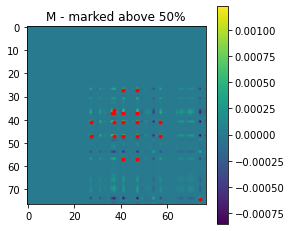

In [21]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B, fact_stats = sg.fit_graph(train_data['des'], train_data['lbls'], sg_params, gd_opt_params, seed)
fact_M = fact_B.T @ fact_B
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))
visualize_M(fact_M, fig_params)

## SDP-GLMNN

In [21]:
# eng.quit()

In [22]:
# start the matlab engine
eng = matlab.engine.start_matlab()

In [23]:
eng.cd(r'../15_cheng/lmnn-offtheshelf/', nargout=0)

In [14]:
# fit the graph
time0 = time.time()
(cvx_M, cvx_delta, cvx_status) = eng.lmnn_cvx_python(swap_path_matlab, idstr, gamma, beta, nargout=3)

Elapsed time is 0.135929 seconds.
Elapsed time is 0.097807 seconds.
n_delta = 15000
Elapsed time is 0.244404 seconds.
 
Calling SeDuMi 1.3.4: 32080 variables, 15000 equality constraints
------------------------------------------------------------
SeDuMi 1.3.4 by AdvOL, 2005-2008 and Jos F. Sturm, 1998-2003.
Alg = 2: xz-corrector, Adaptive Step-Differentiation, theta = 0.250, beta = 0.500


EngineError: MATLAB function cannot be evaluated

cvx_status:  Solved
Elapsed  time: 86.784103 sec


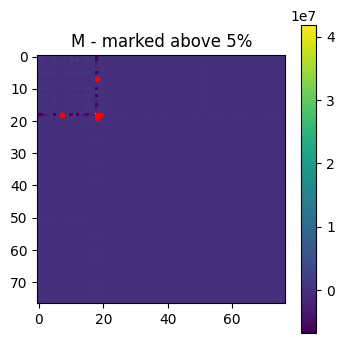

In [19]:
print('cvx_status: ', cvx_status)
cvx_M = np.array(cvx_M)
cvx_delta = np.array(cvx_delta).reshape(-1)
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))
visualize_M(cvx_M, fig_params)

In [20]:
# compute the objective matrix required to compute the training loss
cvx_V = eng.get_objective_variables_ready_python(swap_path_matlab, idstr)
cvx_V = np.array(cvx_V)

In [21]:
cvx_V

array([[ 0.04132483,  0.04139413,  0.03459456, ..., -0.09248525,
         0.03879178,  0.17308389],
       [ 0.04139413,  0.04148952,  0.0324306 , ..., -0.09135734,
         0.03962292,  0.1745608 ],
       [ 0.03459456,  0.0324306 ,  0.21908416, ..., -0.187202  ,
        -0.03307097,  0.04336958],
       ...,
       [-0.09248525, -0.09135734, -0.187202  , ...,  4.3307657 ,
         2.00356212, -0.03806085],
       [ 0.03879178,  0.03962292, -0.03307097, ...,  2.00356212,
         3.38321647,  1.71624055],
       [ 0.17308389,  0.1745608 ,  0.04336958, ..., -0.03806085,
         1.71624055,  4.40056954]])

## GDPA-GLMNN

In [24]:
# change matlab's folder
eng.cd(r'../lmnn-gdpa-2/', nargout=0)

starting SGML.
initial objective value = Inf
1: objective_previous - objective_current = Inf
2: objective_previous - objective_current = 22.322153
3: objective_previous - objective_current = 8.452357
4: objective_previous - objective_current = 0.126262
5: objective_previous - objective_current = 0.000000
1: objective_previous - objective_current = 0.017623
2: objective_previous - objective_current = 0.000000
converged objective value = 136.4785
minimal eigenvalue of M = -0.0001
num_LP_rowcol = 240, num_LP_full = 2done with SGML.
Elapsed  time: 36.328026 sec


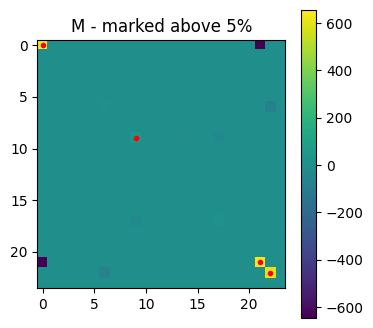

In [25]:
# fit the graph
time0 = time.time()
(gdpa_M, gdpa_delta, num_LP_rowcol, num_LP_full) = eng.lmnn_gdpa_python(swap_path_matlab, idstr, gamma, beta, nargout=4)
gdpa_M = np.array(gdpa_M)
gdpa_delta = np.array(gdpa_delta).reshape(-1)
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))
visualize_M(gdpa_M, fig_params)

In [26]:
# compute the objective matrix required to compute the training loss
gdpa_V = eng.get_objective_variables_ready_python(swap_path_matlab, idstr)
gdpa_V = np.array(gdpa_V)

# sanity check - V should be the same for both CVX and GDPA
assert (gdpa_V == cvx_V).all()

NameError: name 'cvx_V' is not defined

In [25]:
# close the matlab engine
eng.quit()

## Logistic Regression (benchmark)

In [ ]:
# instantiate the logistic regression model
lgrg = LogisticRegression(penalty='none', max_iter=1000000)
# fit model
lgrg = lgrg.fit(train_data['des'], train_data['lbls'])

# Validation

In [35]:
# import importlib
# importlib.reload(sg)

<module 'simgraph.my_simgraph' from 'F:\\Users/yasam/Documents/GitHub/simgraph/code/my_packages\\simgraph\\my_simgraph.py'>

In [36]:
show_edges = False

In [38]:
# GLR
fact_val_mse, fact_y_est, fact_t = sg.get_acc(fact_M, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, 'cat', seed, show_edges)
print('Elapsed time: {:.6f} sec'.format(fact_t))
print('GLR val. MSE = {:.6f}'.format(fact_val_mse))

Elapsed time: 0.039890 sec
GLR val. MSE = 17.389729


In [ ]:
# SDP-GLMNN
cvx_val_acc, cvx_y_est, cvx_t = sg.get_acc(cvx_M, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed, show_edges)
# NOTE: sg_params['edges_vv'] and sg_params['edges_vt'] are fixed now
print('Elapsed time: {:.6f} sec'.format(cvx_t))
print('SDP-GLMNN val. acc. = {:.2f}%'.format(cvx_val_acc*100))

In [ ]:
# GDPA-GLMNN
gdpa_val_acc, gdpa_y_est, gdpa_t = sg.get_acc(gdpa_M, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed, show_edges)
print('Elapsed time: {:.6f} sec'.format(gdpa_t))
print('GDPA-GLMNN val. acc. = {:.2f}%'.format(gdpa_val_acc*100))

In [77]:
# LogReg
time0 = time.time()
lgrg_val_acc = lgrg.score(val_data['des'], val_data['lbls'])
lgrg_y_est = lgrg.predict(val_data['des'])
print('Elapsed time: {:.6f} sec'.format(time.time()-time0))
print('LogReg val. acc. = {:.2f}%'.format(lgrg_val_acc*100))

Elapsed time: 0.002475 sec
LogReg val. acc. = 2.00%


# Compare final loss values

In [29]:
# SDP-GLMNN
cvx_loss = np.sum(cvx_M * cvx_V.T) + beta * np.sum(cvx_delta)
print('CVX-LMNN loss: {:.4f}'.format(cvx_loss))

In [30]:
# GDPA-GLMNN
gdpa_loss = np.sum(gdpa_M * gdpa_V.T) + beta * np.sum(gdpa_delta)
print('GDPA-LMNN loss: {:.4f}'.format(gdpa_loss))

GDPA-LMNN loss: 136.4785


In [39]:
# GLR
fact_loss = sg.cnstr_glr(fact_B, deriv=False, mu=sg_params['mu'], x=train_data['lbls'], F=train_data['des'].T, edges_tt=sg_params['edges_tt'])
print('Fact-GLR&trace loss: {:.4f}'.format(fact_loss))

Fact-GLR&trace loss: 0.0851


## GLMNN loss with GLR optimized metric

In [33]:
edges_tt = np.array(sg_params['edges_tt'])
x = train_data['lbls']
feature = train_data['des']

In [34]:
e2 = 0
for edge_i in range(edges_tt.shape[0]):
    n_i = edges_tt[edge_i,0]
    n_j = edges_tt[edge_i,1]
    if x[n_i] == x[n_j]:
        n_ls = np.append(edges_tt[edges_tt[:,1] == n_i,0], edges_tt[edges_tt[:,0] == n_i,1], axis=0)
        for li in range(n_ls.shape[0]):
            if x[n_ls[li]] == -1*x[n_i]:
                f_ij = feature[n_i] - feature[n_j]
                f_il = feature[n_i] - feature[n_ls[li]]
                F_ijl = np.outer(f_ij, f_ij) - np.outer(f_il, f_il)
                temp = np.sum(fact_M * F_ijl) + gamma
                if temp >= 0:
                    e2 = e2 + temp

cvx_loss_with_fact = np.sum(fact_M * cvx_V.T) + beta * e2
print('SDP-GLMNN loss with Fact-GLR&trace metric: {:.4f}'.format(cvx_loss_with_fact))

CVX-LMNN loss with Fact-GLR&trace metric: 1444.7015
